# HSIC Lasso profiling

To better understand the memory consumption of HSIC lasso, in this notebook I
run a memory profiler on a moderate workload to identify hotspots.

In [1]:
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from pyHSICLasso import HSICLasso, hsic_lasso  # NOQA

from hsic_optimization.benchmark import test_model

## Memory usage profile

Using [memory_profiler](https://github.com/pythonprofilers/memory_profiler),
let's look at the memory consumption over time. I disable the multi-processing
(using `"n_jobs": 1`) to track memory allocation in the most basic case.

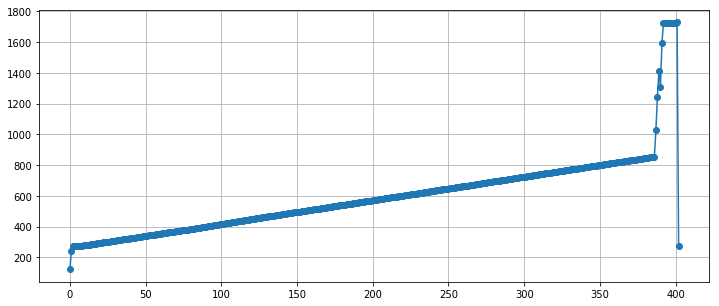

In [2]:
mem_use = memory_usage(
    (test_model, (1600, 1600, 10), {"seed": 12345, "n_jobs": 1}), include_children=True
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)

Interestingly the memory consumption linearly increase in a first case and double
at the end.

Let's see how this behaves if we just double the number of samples (from 1600 to
3200).

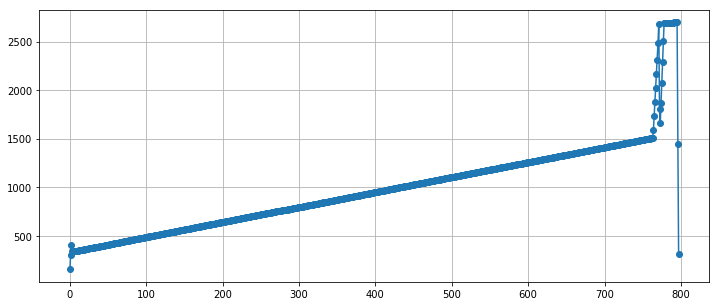

In [3]:
mem_use = memory_usage(
    (test_model, (3200, 1600, 10), {"seed": 12345, "n_jobs": 1}), include_children=True
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)

The memory profile looks very similar, with an obvious scale/offset due to the
larger dataset size.

Next step consists in using multiple workers to create the feature-related
vectors `K`, to check how this affects memory consumption.

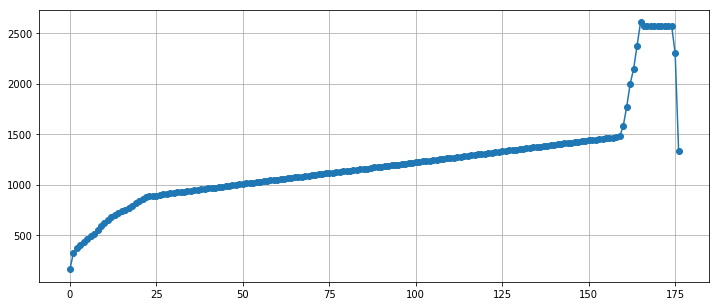

In [4]:
mem_use = memory_usage(
    (test_model, (1600, 1600, 10), {"seed": 12345, "n_jobs": 4}), include_children=True
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)

The only difference is a faster increase of the memory consumption at the beginning.

## Line-by-line analysis

Next, I'll use `memory_profiler` extension to print line-by-line memory usage.

In [5]:
%load_ext memory_profiler

In [6]:
%%mprun -f test_model
test_model(1600, 1600, 10, seed=12345, n_jobs=1)

Filename: /scale_wlg_persistent/filesets/project/nesi99999/riom/hsic_optimization/src/hsic_optimization/benchmark.py

Line #    Mem usage    Increment  Occurences   Line Contents
    32    661.3 MiB    661.3 MiB           1   def test_model(nsamples, ncols, nfeats, seed, **kwargs):
    33    719.7 MiB     58.5 MiB           1       X, Y = generate_data(nsamples, ncols, nfeats, seed)
    34    719.7 MiB      0.0 MiB           1       hsic_lasso = HSICLasso()
    35    719.7 MiB      0.0 MiB           1       hsic_lasso.input(X, Y)
    36    719.7 MiB      0.0 MiB           1       with open(os.devnull, "w") as fd, contextlib.redirect_stdout(fd):
    37   1306.4 MiB    586.7 MiB           1           hsic_lasso.classification(num_feat=nfeats, **kwargs)
    38   1306.4 MiB      0.0 MiB           1       return np.mean(hsic_lasso.get_index() == np.arange(nfeats))

The majority of the memory consumption comes from `hsic_lasso.classification`
method call. This is just a wrapper for `HSICLasso._run_hsic_lasso` method, so
we can dig into this one to get more information.

In [7]:
%%mprun -f HSICLasso._run_hsic_lasso
test_model(1600, 1600, 10, seed=12345, n_jobs=1)

Filename: /home/riom/project/hsic_optimization/venv/lib/python3.8/site-packages/pyHSICLasso/api.py

Line #    Mem usage    Increment  Occurences   Line Contents
    91    720.4 MiB    720.4 MiB           1       def _run_hsic_lasso(self, y_kernel, num_feat, B, M, discrete_x, max_neighbors, n_jobs, covars, covars_kernel):
    92                                         
    93    720.4 MiB      0.0 MiB           1           if self.X_in is None or self.Y_in is None:
    94                                                     raise UnboundLocalError("Input your data")
    95    720.4 MiB      0.0 MiB           1           self.max_neighbors = max_neighbors
    96    720.4 MiB      0.0 MiB           1           n = self.X_in.shape[1]
    97    720.4 MiB      0.0 MiB           1           B = B if B else n
    98    720.4 MiB      0.0 MiB           1           x_kernel = "Delta" if discrete_x else "Gaussian"
    99    720.4 MiB      0.0 MiB           1           numblocks = n / B
   100    7

The memory consumption increases when creating the feature-related vectors `K`
using the `hsic_lasso` function. Surprisingly, it seems that line 120 also
double the memory consumption (transiently I suppose) due to the allocation of a
new array instead of reusing `X` to store the results.

In [8]:
%%mprun -f hsic_lasso
test_model(1600, 1600, 10, seed=12345, n_jobs=1)

Filename: /home/riom/project/hsic_optimization/venv/lib/python3.8/site-packages/pyHSICLasso/hsic_lasso.py

Line #    Mem usage    Increment  Occurences   Line Contents
    18    720.5 MiB    720.5 MiB           1   def hsic_lasso(X, Y, y_kernel, x_kernel='Gaussian', n_jobs=-1, discarded=0, B=0, M=1):
    19                                             """
    20                                             Input:
    21                                                 X      input_data
    22                                                 Y      target_data
    23                                                 y_kernel  We employ the Gaussian kernel for inputs. For output kernels,
    24                                                           we use the Gaussian kernel for regression cases and
    25                                                           the delta kernel for classification problems.
    26                                             Output:
    27                  

The `Parallel` call creates all the feature-related vectors `K`, accounting for
the memory increase of the function. The concatenation operation on line 48 also
transiently increases the memory consumption (double it), until `result` gets
garbage collected, probably when the function returns.